In [1]:
import xarray as xr
import xclim as xc

import matplotlib.pyplot as plt

# Fire Weather Index calculation using xclim

[Details on the xclim implementation are here](https://xclim.readthedocs.io/en/stable/indices.html)

In [2]:
# Select one year!
year = '2000'

In [3]:
# Read relevant files
files = ['tmmx_' + year, 'rmin_' + year, 'pr_' + year, 'vs_' + year]
files = ['/data/rsriver/c/davidcl2/METDATA/' + file + '.nc' for file in files]

# Import and concatenate using Xarray
ds = [xr.open_dataset(file) for file in files]
ds = xr.merge(ds)

In [4]:
ds

<xarray.Dataset>
Dimensions:               (lon: 1386, lat: 585, day: 366, crs: 1)
Coordinates:
  * lon                   (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                   (lat) float64 25.07 25.11 25.15 ... 49.32 49.36 49.4
  * day                   (day) datetime64[ns] 2000-01-01 ... 2000-12-31
  * crs                   (crs) int32 1
Data variables:
    air_temperature       (day, lat, lon) float32 ...
    relative_humidity     (day, lat, lon) float32 ...
    precipitation_amount  (day, lat, lon) float32 ...
    wind_speed            (day, lat, lon) float32 ...
Attributes: (12/18)
    author:                     John Abatzoglou - University of Idaho, jabatz...
    date:                       09 March 2016
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    last_permanent_slice:       366
    note3:                      Data in slices after last_permanent_slice (1-...
    ...                         ...
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial_lat_units:       decimal_degrees north
    geospatial_lon_units:       decimal_degrees east
    coordinate_system:          EPSG:4326

In [5]:
# Add some corrections for xclim
ds.precipitation_amount.attrs['units'] = 'mm/day'
ds = ds.rename({'day':'time'})

In [6]:
%%time
# Calculate FWI
out = xc.indices.fire_weather_indexes(
    ds['air_temperature'],
    ds['precipitation_amount'],
    ds['wind_speed'],
    ds['relative_humidity'],
    ds.lat
)

/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/xclim/indices/fwi.py:825: RuntimeWarning: invalid value encountered in _drought_code
  out["DC"][..., it] = _drought_code(
/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/xclim/indices/fwi.py:829: RuntimeWarning: invalid value encountered in _duff_moisture_code
  out["DMC"][..., it] = _duff_moisture_code(
/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/xclim/indices/fwi.py:838: RuntimeWarning: invalid value encountered in _fine_fuel_moisture_code
  out["FFMC"][..., it] = _fine_fuel_moisture_code(
/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/xclim/indices/fwi.py:825: RuntimeWarning: invalid value encountered in _drought_code
  out["DC"][..., it] = _drought_code(
/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/xclim/indices/fwi.py:469: RuntimeWarning: invalid value 

CPU times: user 3min 15s, sys: 12.5 s, total: 3min 27s
Wall time: 3min 34s


In [8]:
# Combine into xr dataset
names = ["DC", "DMC", "FFMC", "ISI", "BUI", "FWI"]
out_dict = dict([(names[i], out[i]) for i in range(len(out))])
out = xr.Dataset(data_vars=out_dict, attrs=ds.attrs)

# Update attributes
out.attrs['note3'] = 'Fire Weather indices calculated using xclim python package v0.23.0 with tas, pr, ws, rh, lat as inputs and all other parameters set to default'
out.DC.attrs['description'] = "Drought Code"
out.DMC.attrs['description'] = "Duff Moisture Code"
out.FFMC.attrs['description'] = "Fine Fuel Moisture Code"
out.ISI.attrs['description'] = "Initial Spread Index"
out.BUI.attrs['description'] = "Build-up Index"
out.FWI.attrs['description'] = "Fire Weather Index"

In [9]:
out

<xarray.Dataset>
Dimensions:  (lon: 1386, lat: 585, time: 366)
Coordinates:
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -67.14 -67.1 -67.06
  * lat      (lat) float64 25.07 25.11 25.15 25.19 ... 49.28 49.32 49.36 49.4
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
Data variables:
    DC       (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    DMC      (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    FFMC     (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    ISI      (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    BUI      (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    FWI      (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/18)
    author:                     John Abatzoglou - University of Idaho, jabatz...
    date:                       09 March 2016
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    last_permanent_slice:       366
    note3:                      Fire Weather indices calculated using xclim p...
    ...                         ...
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatial_lat_units:       decimal_degrees north
    geospatial_lon_units:       decimal_degrees east
    coordinate_system:          EPSG:4326

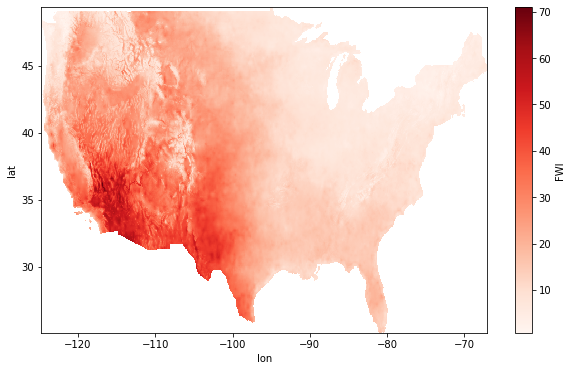

In [19]:
# Sample plot: annual average
fig, ax = plt.subplots(figsize=(10,6))

out['FWI'].mean(dim='time').plot(cmap='Reds', ax=ax)

plt.show()

In [18]:
# One year is around 7GB!
out.nbytes / 1e9

7.122173736

In [ ]:
# # Save if you dare...
# out.to_netcdf('./fire-indices.nc')

## Speed up with dask

3 mins per year x (55 years (hist) + 95 years (RCPs)) = too long! We can speed up using dask... I ran into difficulties when doing this the traditional way (using `xr.open_mfdataset` on all years and then calculating FWI as above) so instead we can use [dask delayed](https://docs.dask.org/en/stable/delayed.html)

### Set up cluster

In [1]:
from dask_jobqueue import SLURMCluster

/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
cluster = SLURMCluster(cores=1,
                       processes=1,
                       memory="16GB")

In [3]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=15G
#SBATCH -t 00:30:00
#SBATCH -C g20

/data/keeling/a/davidcl2/anaconda3/envs/climate_stack/bin/python -m distributed.cli.dask_worker tcp://172.22.178.86:37379 --nthreads 1 --memory-limit 14.90GiB --name dummy-name --nanny --death-timeout 60 --protocol tcp://



In [4]:
cluster.scale(10)

In [5]:
from dask.distributed import Client

In [6]:
client = Client(cluster)

In [7]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.178.86:37379,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


The [dashboard](https://docs.dask.org/en/stable/diagnostics-distributed.html) above is a very useful way to monitor computations using dask. Make sure you have the `jobqueue.yaml` file in this repository copied into `$HOME/.config/dask/` on keeling in order to access it!

### Dask delayed to parallelize by year

In [7]:
def calculate_FWI(year):
    year = str(year)
    
    # Read relevant files
    files = ['tmmx_' + year, 'rmin_' + year, 'pr_' + year, 'vs_' + year]
    files = ['/data/rsriver/c/davidcl2/METDATA/' + file + '.nc' for file in files]

    # Import and concatenate using Xarray
    ds = [xr.open_dataset(file) for file in files]
    ds = xr.merge(ds)
    
    # Add some corrections for xclim
    ds.precipitation_amount.attrs['units'] = 'mm/day'
    ds = ds.rename({'day':'time'})
    
    # Calculate FWI
    out = xc.indices.fire_weather_indexes(
    ds['air_temperature'],
    ds['precipitation_amount'],
    ds['wind_speed'],
    ds['relative_humidity'],
    ds.lat)
    
    # Combine into xr dataset
    names = ["DC", "DMC", "FFMC", "ISI", "BUI", "FWI"]
    out_dict = dict([(names[i], out[i]) for i in range(len(out))])
    out = xr.Dataset(data_vars=out_dict, attrs=ds.attrs)

    # Update attributes
    out.attrs['note3'] = 'Fire Weather indices calculated using xclim python package v0.23.0 with tas, pr, ws, rh, lat as inputs and all other parameters set to default'
    out.DC.attrs['description'] = "Drought Code"
    out.DMC.attrs['description'] = "Duff Moisture Code"
    out.FFMC.attrs['description'] = "Fine Fuel Moisture Code"
    out.ISI.attrs['description'] = "Initial Spread Index"
    out.BUI.attrs['description'] = "Build-up Index"
    out.FWI.attrs['description'] = "Fire Weather Index"
    
    # Save
    # out.to_netcdf(path_to_directory + 'METDATA_FWI_' + str(year) + '.nc')

In [8]:
import dask

In [9]:
# Parallelize with dask
delayed = []
for year in range(1979, 1983):
    tmp = dask.delayed(calculate_FWI)(year)
    delayed.append(tmp)

In [10]:
delayed

[Delayed('calculate_FWI-e8ba256f-43be-4f3b-8603-bd457d478663'),
 Delayed('calculate_FWI-e04269e3-6ff8-49fa-a29a-66000bff2c8e'),
 Delayed('calculate_FWI-3704d3ae-869f-4ade-a36f-13832abf7958'),
 Delayed('calculate_FWI-717e2dc2-21e0-4300-8f73-a3261e22e56f')]

In [ ]:
# Trigger computation
res = dask.compute(*delayed)

# NOTE: currently the calculate_FWI function does not return anything... 
# it would probably be better to save the resulting netcdf files since
# they are too large to hold in memory